In [1]:
# !pip install imblearn

In [33]:
import time, datetime
import requests 
import pickle as pkl 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange
import json

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn import metrics
import time
from sklearn.model_selection import ShuffleSplit

import itertools

import warnings
warnings.filterwarnings('ignore')


from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

from sklearn.model_selection import cross_val_score, cross_validate

from sklearn.model_selection import train_test_split

import imblearn
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

from scipy import stats
import pprint
import seaborn as sns

#models 
from sklearn.cluster import DBSCAN
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

from sklearn.ensemble import VotingClassifier  

from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

from collections import Counter

In [34]:
# create input and output data

data = pd.read_csv("mts_june_10m_rh.csv", dtype='float').drop(['Unnamed: 0'], axis=1)

X = data.drop(['cs'], axis=1)
Y = data['cs']

# data = pd.read_pickle(r'all_metrics_data_3h.pkl')
# data = pd.read_pickle(r'all_metrics_data_12h.pkl')

# X = data.drop(['time', 'label', "txn_fail_num"], axis=1)
# Y = data.label
print(len(data))
print(len(data[data.cs == 1]))
print(len(data[data.cs == 0]))

28311
24553
3758


# PCA

In [35]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler


scaler = MinMaxScaler()
scaled_df = scaler.fit_transform(X)

pca = PCA(n_components = 0.95)
pca_df = pca.fit_transform(scaled_df)
pca.fit(X)

PCA(n_components=0.95)

In [36]:
correlation_txn_falure = {}

for label in X.columns:
    r,p = stats.pearsonr(X[label],Y)
    correlation_txn_falure[label] = (r,p)
    

In [37]:
txn_falure_correlation = pd.DataFrame.from_dict(correlation_txn_falure, orient='index').rename(columns={0:'r', 1:'p-value'}).sort_values('r', ascending=False)

<AxesSubplot:>

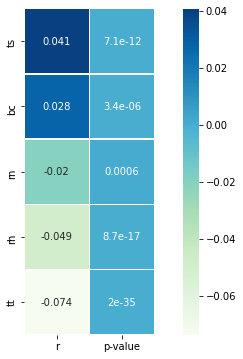

In [38]:
plt.figure(figsize=(10,6))
sns.heatmap(txn_falure_correlation, cmap='GnBu', square=True, annot=True, linewidths=.5)

<AxesSubplot:>

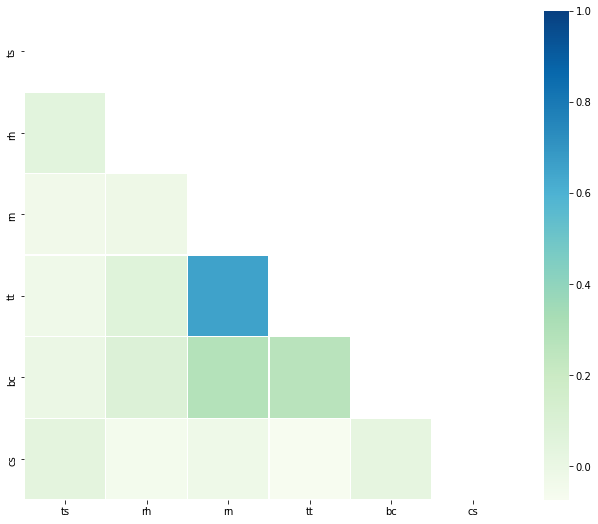

In [39]:
correlations = data.corr().dropna(axis=1, how='all').T.dropna(axis=1, how='all').T
# heatmap

matrix = np.triu(correlations)

plt.figure(figsize=(11,9))
sns.heatmap(correlations, cmap='GnBu', square=True, annot=False, linewidths=.5, mask=matrix)
#plt.savefig('xx.png')

In [40]:
df_index = list(txn_falure_correlation.index)

# drop Nan
txn_falure_correlation = txn_falure_correlation.dropna(axis='rows')
txn_falure_correlation.head(10)

,r,p-value
ts,0.040725,7.134239e-12
bc,0.027616,3.362653e-06
rn,-0.020392,6.007836e-04
rh,-0.049427,8.699338e-17
tt,-0.073715,2.045137e-35


In [41]:
selected_features = txn_falure_correlation[np.abs(txn_falure_correlation.r) >0.5]
selected_features = selected_features[selected_features['p-value'] < 0.05]

selected_features_names = selected_features.index

# Validate Models 

In [10]:
from sklearn.model_selection import StratifiedShuffleSplit

def evaluate(y_real, y_pred):
    from sklearn import metrics
    accuracy = accuracy_score(y_real,y_pred)
    precision = precision_score(y_real, y_pred, average='macro')
    recall = metrics.recall_score(y_real, y_pred, average='macro')
    f1_score = metrics.f1_score(y_real, y_pred, average='macro') 
    
    # AUC curve
    fpr, tpr, threshold = metrics.roc_curve(y_real, y_pred)
    roc_auc = metrics.auc(fpr, tpr)
    return accuracy, precision, recall, f1_score, fpr, tpr, roc_auc

# since boolean predictions may be wrong way around
def result(y_real, y_pred):
    from sklearn import metrics
    if  metrics.f1_score(y_real, y_pred, average='macro') >  metrics.f1_score(y_real, [not y for y in y_pred], average='macro'):
        return evaluate(y_real, y_pred)
    else:
        return evaluate(y_real, [not y for y in y_pred])

def show_res(res):
    accuracy, precision, recall, f1_score,fpr, tpr, roc_auc, time = res
    print("Accuracy", accuracy)
    print("Precision", precision)
    print("Recall", recall)
    print("F1 Score", f1_score)
    print("Time", time)
    
def flip_if_inverted(Y_pred):
    Y_pred = np.array([0 if i != 1 else 1 for i in Y_pred ])
    if len(Y_pred[Y_pred == 1]) < len(Y_pred[Y_pred == 0]):
        
        return [not elem for elem in Y_pred]
    else:
        return Y_pred
    
def validate_model(model, X, Y,undersample=False, oversample=False, flip=True):
    accuracy_, precision_, recall_, f1_score_,fpr_, tpr_, roc_auc_, time_ = [],[],[],[],[], [],[],[]

    shuffle_split = StratifiedShuffleSplit(n_splits=5, test_size=0.4, random_state=0)
    for train_index, test_index in shuffle_split.split(X,Y):
        start_time = time.time()
        
        if type(X) == pd.DataFrame:
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]
        else:
            X_train, X_test = X[train_index], X[test_index]
            Y_train, Y_test = Y[train_index], Y[test_index]
        if undersample:
            undersampling = RandomUnderSampler(sampling_strategy="majority")
            X_train, Y_train = undersampling.fit_resample(X_train, Y_train)

        if oversample:
            oversampling = RandomOverSampler(sampling_strategy="minority")
            X_train, Y_train = oversampling.fit_resample(X_train, Y_train)

        fitted_model = model.fit(X_train, Y_train)
        try:
            y_pred = fitted_model.predict(X_test)
        except:
            y_pred = fitted_model.fit_predict(X_test)
        ####
        #### IS THIS ALLOWED?
        ####
        ####
        if flip:
            y_pred = flip_if_inverted(y_pred)
        
        accuracy, precision, recall, f1_score, fpr, tpr, roc_auc = result(Y_test, y_pred)
    
        end_time = time.time()
        fpr_.append(fpr)
        tpr_.append(tpr)
        
        accuracy_.append(accuracy)
        precision_.append(precision)
        recall_.append(recall)
        f1_score_.append(f1_score)
        roc_auc_.append(roc_auc)
        time_.append(end_time - start_time)  
    return np.mean(accuracy_), np.mean(precision_), np.mean(recall_), np.mean(f1_score_), np.mean(time_)


In [11]:
# Models

In [12]:
dbscan_model = DBSCAN(eps=3, min_samples=2)
isolation_forest_model = IsolationForest(n_estimators=100, max_samples='auto', contamination=float(.12), \
                        max_features=1.0, bootstrap=False, n_jobs=-1, random_state=42, verbose=0)
kmeans_model = KMeans(n_clusters=2)
knn_model = KNeighborsClassifier()
svm_model = make_pipeline(StandardScaler(), SVC(gamma='auto'))
rf_model = RandomForestClassifier(max_depth=10, random_state=5)

all_models = [dbscan_model, isolation_forest_model, kmeans_model, knn_model, svm_model, rf_model]
unsupervised_models = [dbscan_model, isolation_forest_model, kmeans_model]
supervised_models = [knn_model, svm_model, rf_model]

In [13]:
# Ensemble

In [14]:
supervised_voting_model = VotingClassifier(estimators=[
        ('knn', knn_model), \
        ('svm', svm_model),('random forest', rf_model)], voting='hard', weights=[1,1,1])


print("All metrics")
print(validate_model(supervised_voting_model, X,Y))
print(validate_model(supervised_voting_model, pca_df,Y))


All metrics
(0.9748262548262548, 0.963320369314889, 0.9759667024704617, 0.9692973874232719, 0.777504301071167)
(0.972972972972973, 0.9617317910570131, 0.9726699991737586, 0.9669658044046778, 0.4693434715270996)


In [15]:
def optimize_voting_parameters(X,Y, w1, w2,w3):
    tuning_res = pd.DataFrame(columns = ["w1", "w2", 'w3', "accuracy", "precision", "recall",\
                                         "f1_score", "fpr", "tpr", "roc_auc", "time"])

    for w1_, w2_, w3_ in itertools.product(*[w1, w2,w3]):
        dbscan_clf = DBSCAN(eps=3, min_samples=2)
        if_clf=IsolationForest(n_estimators=100, max_samples='auto', contamination=float(.12), \
                                max_features=1.0, bootstrap=False, n_jobs=-1, random_state=42, verbose=0)
        kmeans_clf = KMeans(n_clusters=2)
        KNN_clf = KNeighborsClassifier(n_neighbors=2)
        svm_clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
        rf_clf = RandomForestClassifier(max_depth=10, random_state=5)      

        # dbscan, IF and kmeans does not work since it is no classifier
        model = VotingClassifier(estimators=[
                ('knn', KNN_clf), \
                ('svm', svm_clf),('random forest', rf_clf)], voting='hard', weights=[w1_, w2_, w3_])
        validate_model(model, X,Y)

        accuracy, precision, recall, f1_score, fpr, tpr, roc_auc, time = \
                validate_model(model, X, Y)
        
        row = {"w1":w1_, "w2":w2_, 'w3':w3_,"accuracy":accuracy, "precision":precision,\
               "recall":recall, "f1_score":f1_score, "fpr":fpr, "tpr":tpr, "roc_auc":roc_auc}
        tuning_res = tuning_res.append(row, ignore_index=True)
    return tuning_res.sort_values("f1_score", ascending=False)

In [16]:
def weighted_vote_ensamble(X,Y, models, weights=[1,1,1,1,1,1], undersample=False, oversample=False):
    accuracy_, precision_, recall_, f1_score_,fpr_, tpr_, roc_auc_, time_ = [],[],[],[],[], [],[],[]

    shuffle_split = StratifiedShuffleSplit(n_splits=5, test_size=0.4, random_state=0)
    for train_index, test_index in shuffle_split.split(X,Y):
        start_time = time.time()
        
        if type(X) == pd.DataFrame:
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]
        else:
            X_train, X_test = X[train_index], X[test_index]
            Y_train, Y_test = Y[train_index], Y[test_index]
        if undersample:
            undersampling = RandomUnderSampler(sampling_strategy="majority")
            X_train, Y_train = undersampling.fit_resample(X_train, Y_train)

        if oversample:
            oversampling = RandomOverSampler(sampling_strategy="minority")
            X_train, Y_train = oversampling.fit_resample(X_train, Y_train)

        
        start_time = time.time()
        
        results = []
        for model, weight in zip(models, weights):
            try:
                model.fit(X_train, Y_train)
                for i in range(weight):
                    res = model.predict(X_test)
                    res = flip_if_inverted(res)
                    results.append(res)
            except:
                for i in range(weight):
                    res =  model.fit_predict(X_test)
                    res[res == -1] = 1
                    res = flip_if_inverted(res)
                    results.append(res)

        results = np.array(results)      
        # find majority
        results=results.T
        
        final_res = []
        for i in list(results):
            final_res.append(int(Counter(i).most_common(1)[0][0]))
        end_time = time.time()
        
        accuracy, precision, recall, f1_score, fpr, tpr, roc_auc = result(Y_test, final_res)
        
        fpr_.append(fpr)
        tpr_.append(tpr)
        
        accuracy_.append(accuracy)
        precision_.append(precision)
        recall_.append(recall)
        f1_score_.append(f1_score)
        roc_auc_.append(roc_auc)
        time_.append(end_time - start_time)  
        
    return np.mean(accuracy_), np.mean(precision_), np.mean(recall_), np.mean(f1_score_), np.mean(time_)
        

In [17]:
weighted_vote_ensamble(X,Y, models = supervised_models, weights=[1,1,1], undersample=False, oversample=False)


(0.9748262548262548,
 0.963320369314889,
 0.9759667024704617,
 0.9692973874232719,
 0.7491046905517578)

In [18]:
weighted_vote_ensamble(X,Y, models = unsupervised_models, weights=[1,1,1], undersample=False, oversample=False)


(0.7045559845559846,
 0.49044830557724267,
 0.4990456911509543,
 0.43909033851436413,
 2.300420045852661)

In [19]:
def optimize_all_voting_parameters(X,Y, weight_permutations, undersample=False, oversample=False):
    tuning_res = pd.DataFrame(columns = ["w1", "w2", 'w3', 'w4', 'w5','w6', "accuracy", "precision", "recall",\
                                         "f1_score", "fpr", "tpr", "roc_auc", "time"])
   
    for permutation in weight_permutations:
        start_time = time.time()
        w1_, w2_, w3_, w4_,w5_,w6_ = permutation
        
        accuracy, precision, recall, f1_score, fpr, tpr, roc_auc, time_ = \
            weighted_vote_ensamble(X,Y, weights=list(permutation), undersample=undersample, oversample=oversample)


        end_time=time.time()
        row = {"w1":w1_, "w2":w2_, 'w3':w3_,'w4':w4_,'w5':w5_, 'w6':w6_,"accuracy":accuracy, "precision":precision,\
               "recall":recall, "f1_score":f1_score, "fpr":fpr, "tpr":tpr, "roc_auc":roc_auc, 'time':end_time-start_time}
        tuning_res = tuning_res.append(row, ignore_index=True)
    return tuning_res.sort_values("f1_score", ascending=False)

In [20]:
from vecstack import stacking
from xgboost import XGBClassifier


def stack(X,Y, models, undersample=False, oversample=False):
    X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.4, random_state=22)

    if undersample:
        undersampling = RandomUnderSampler(sampling_strategy="majority")
        X_train, Y_train = undersampling.fit_resample(X_train, Y_train)
            
    if oversample:
        oversamping = RandomOverSampler(sampling_strategy="minority")
        X_train, Y_train = oversamping.fit_resample(X_train, Y_train)
            
    start_time = time.time()
    S_train, S_test = stacking(models,                   
                                X_train, Y_train, X_test,   
                               regression=False, 

                                mode='oof_pred_bag', 

                               needs_proba=False,

                               save_dir=None, 

                               metric=accuracy_score, 

                               n_folds=4, 

                               stratified=True,

                               shuffle=True,  

                               random_state=0,    

                               verbose=2)

    model = XGBClassifier(random_state=0, n_jobs=-1, learning_rate=0.1,
                          n_estimators=100, max_depth=3)
    model = model.fit(S_train, Y_train)

    y_pred = model.predict(S_test)
    
    accuracy, precision, recall, f1_score, fpr, tpr, roc_auc = result(Y_test, y_pred)
    
    end_time = time.time()
    
    return accuracy, precision, recall, f1_score, end_time - start_time
    


In [21]:
def table(x1, x2, x3, method):
    if x1:
        accuracy1, precision1, recall1, f1_score1, time1 = x1
        print(f"{method} & {accuracy1:.2f} &{precision1:.2f}& {recall1:.2f} & {f1_score1:.2f} & {time1:.2f} &",end="")
    if x2:
        accuracy2, precision2, recall2, f1_score2, time2 = x2
        print(f"{accuracy2:.2f} &{precision2:.2f}& {recall2:.2f} &{f1_score2:.2f}& {time2:.2f} & ",end="")
    if x3:
        accuracy3, precision3, recall3, f1_score3, time3 = x3
    print(f"{accuracy3:.2f} &{precision3:.2f}& {recall3:.2f} & {f1_score3:.2f} & {time3:.2f} \\\\ \\hline")

In [45]:
df1 = X
df2 = X[selected_features_names].copy()
df3 = pca_df.copy()

In [39]:
x1 = validate_model(isolation_forest_model, df1,Y)
# x2 = validate_model(isolation_forest_model, df2,Y)
x2= None
x3 = validate_model(isolation_forest_model, df3,Y)
table(x1, x2, x3, "IF")

x1 = validate_model(dbscan_model, df1,Y)
# x2 = validate_model(dbscan_model, df2,Y)
x3 = validate_model(dbscan_model, df3,Y)
table(x1, x2, x3, "DBSCAN")

x1 = validate_model(kmeans_model, df1,Y)
# x2 = validate_model(kmeans_model, df2,Y)
x3 = validate_model(kmeans_model, df3,Y)
table(x1, x2, x3, "K-means")

x1 = validate_model(knn_model, df1,Y)
# x2 = validate_model(knn_model, df2,Y)
x3 = validate_model(knn_model, df3,Y)
table(x1, x2, x3, "KNN")

x1 = validate_model(svm_model, df1,Y)
# x2 = validate_model(svm_model, df2,Y)
x3 = validate_model(svm_model, df3,Y)
table(x1, x2, x3, "SVM")

x1 = validate_model(rf_model, df1,Y)
# x2 = validate_model(rf_model, df2,Y)
x3 = validate_model(rf_model, df3,Y)
table(x1, x2, x3, "RF")

IF & 0.79 &0.53& 0.52 & 0.52 & 0.84 &0.79 &0.54& 0.53 & 0.53 & 0.82 \\ \hline
DBSCAN & 0.87 &0.43& 0.50 & 0.46 & 0.18 &0.87 &0.43& 0.50 & 0.46 & 3.54 \\ \hline
K-means & 0.87 &0.48& 0.50 & 0.46 & 1.34 &0.54 &0.49& 0.47 & 0.43 & 1.57 \\ \hline
KNN & 0.87 &0.70& 0.61 & 0.64 & 0.32 &0.90 &0.79& 0.71 & 0.74 & 0.29 \\ \hline
SVM & 0.87 &0.75& 0.50 & 0.47 & 9.24 &0.87 &0.43& 0.50 & 0.46 & 5.36 \\ \hline
RF & 0.93 &0.88& 0.79 & 0.82 & 1.44 &0.89 &0.86& 0.59 & 0.61 & 1.30 \\ \hline


In [23]:
x1 = validate_model(isolation_forest_model, df1,Y, oversample=True)
# x2 = validate_model(isolation_forest_model, df1,Y, oversample=True)
x3 = validate_model(isolation_forest_model, df1,Y, oversample=True)
table(x1, x2, x3, "IF")

x1 = validate_model(dbscan_model, df1,Y, oversample=True)
# x2 = validate_model(dbscan_model, df2,Y, oversample=True)
x3 = validate_model(dbscan_model, df3,Y, oversample=True)
table(x1, x2, x3, "DBSCAN")

x1 = validate_model(kmeans_model, df1,Y, oversample=True)
# x2 = validate_model(kmeans_model, df2,Y, oversample=True)
x3 = validate_model(kmeans_model, df3,Y, oversample=True)
table(x1, x2, x3, "K-means")

x1 = validate_model(knn_model, df1,Y, oversample=True)
# x2 = validate_model(knn_model, df2,Y, oversample=True)
x3 = validate_model(knn_model, df3,Y, oversample=True)
table(x1, x2, x3, "KNN")

x1 = validate_model(svm_model, df1,Y, oversample=True)
# x2 = validate_model(svm_model, df2,Y, oversample=True)
x3 = validate_model(svm_model, df3,Y, oversample=True)
table(x1, x2, x3, "SVM")

x1 = validate_model(rf_model, df1,Y, oversample=True)
# x2 = validate_model(rf_model, df2,Y, oversample=True)
x3 = validate_model(rf_model, df3,Y, oversample=True)
table(x1, x2, x3, "RF")

NameError: name 'x2' is not defined

In [ ]:
x1 = validate_model(isolation_forest_model, df1,Y, undersample=True)
# x2 = validate_model(isolation_forest_model, df1,Y, undersample=True)
x3 = validate_model(isolation_forest_model, df1,Y, undersample=True)
table(x1, x2, x3, "IF")

x1 = validate_model(dbscan_model, df1,Y, undersample=True)
# x2 = validate_model(dbscan_model, df2,Y, undersample=True)
x3 = validate_model(dbscan_model, df3,Y, undersample=True)
table(x1, x2, x3, "DBSCAN")

x1 = validate_model(kmeans_model, df1,Y, undersample=True)
# x2 = validate_model(kmeans_model, df2,Y, undersample=True)
x3 = validate_model(kmeans_model, df3,Y, undersample=True)
table(x1, x2, x3, "K-means")

x1 = validate_model(knn_model, df1,Y, undersample=True)
# x2 = validate_model(knn_model, df2,Y, undersample=True)
x3 = validate_model(knn_model, df3,Y, undersample=True)
table(x1, x2, x3, "KNN")

x1 = validate_model(svm_model, df1,Y, undersample=True)
# x2 = validate_model(svm_model, df2,Y, undersample=True)
x3 = validate_model(svm_model, df3,Y, undersample=True)
table(x1, x2, x3, "SVM")

x1 = validate_model(rf_model, df1,Y, undersample=True)
# x2 = validate_model(rf_model, df2,Y, undersample=True)
x3 = validate_model(rf_model, df3,Y, undersample=True)
table(x1, x2, x3, "RF")

In [ ]:
# Ensemble

In [46]:
x1 = stack(df1,Y, unsupervised_models[1:], undersample=False, oversample=False)
# x2 = stack(df2,Y, unsupervised_models[1:], undersample=False, oversample=False)
x3 = stack(df3,Y, unsupervised_models[1:], undersample=False, oversample=False)

table(x1, x2, x3, "Unsupervised stacking")

x1 = stack(df1,Y, supervised_models, undersample=False, oversample=False)
# x2 = stack(df2,Y, supervised_models, undersample=False, oversample=False)
x3 = stack(df3,Y, supervised_models, undersample=False, oversample=False)

table(x1, x2, x3, "Supervised stacking")

x1 = stack(df1,Y, all_models[1:], undersample=False, oversample=False)
# x2 = stack(df2,Y, all_models[1:], undersample=False, oversample=False)
x3 = stack(df3,Y, all_models[1:], undersample=False, oversample=False)

table(x1, x2, x3, "All model stacking")

model = VotingClassifier(estimators=[
        ('knn', knn_model), \
        ('svm', svm_model),('random forest', rf_model)], voting='hard', weights=[1,1,1])

# voting classifier
x1 = validate_model(model, df1,Y)
# x2 = validate_model(model, df2,Y)
x3 = validate_model(model, df3,Y)
table(x1, x2, x3, "Supervised majority voting")

# voting classifier
model = VotingClassifier(estimators=[
        ('knn', knn_model), \
        ('svm', svm_model),('random forest', rf_model)], voting='hard', weights=[0,3,2])
x1 = validate_model(model, df1,Y)
model = VotingClassifier(estimators=[
        ('knn', knn_model), \
        ('svm', svm_model),('random forest', rf_model)], voting='hard', weights=[2,0,3])
# x2 = validate_model(model, df2,Y)
model = VotingClassifier(estimators=[
        ('knn', knn_model), \
        ('svm', svm_model),('random forest', rf_model)], voting='hard', weights=[0,3,2])
x3 = validate_model(model, df3,Y)
table(x1, x2, x3, "Supervised weighted voting")


x1 = weighted_vote_ensamble(df1,Y, models=unsupervised_models, weights=[1,1,1])
# x2 = weighted_vote_ensamble(df2,Y, models=unsupervised_models, weights=[1,1,1])
x3 = weighted_vote_ensamble(df3,Y, models=unsupervised_models, weights=[1,1,1])
table(x1, x2, x3, "Unsupervised majority voting")

# voting using all classifiers
x1 = weighted_vote_ensamble(df1,Y, models=all_models, weights=[0,3,2])
# x2 = weighted_vote_ensamble(df2,Y, models=all_models, weights=[0,3,2])
x3 = weighted_vote_ensamble(df3,Y, models=all_models, weights=[0,3,2])
table(x1, x2, x3, "Unsupervised weighted voting")

x1 = weighted_vote_ensamble(df1,Y, models=all_models, weights=[1,1,1,1,1,1])
# x2 = weighted_vote_ensamble(df2,Y, models=all_models, weights=[1,1,1,1,1,1])
x3 = weighted_vote_ensamble(df3,Y, models=all_models, weights=[1,1,1,1,1,1])
table(x1, x2, x3, "all models majority voting")

x1 = weighted_vote_ensamble(df1,Y, models=all_models, weights=[3,1,1,3,2,2])
# x2 = weighted_vote_ensamble(df2,Y, models=all_models, weights=[3,1,1,3,2,2])
x3 = weighted_vote_ensamble(df3,Y, models=all_models, weights=[3,1,1,3,2,2])
table(x1, x2, x3, "all models weighted voting")

task:         [classification]
n_classes:    [2]
metric:       [accuracy_score]
mode:         [oof_pred_bag]
n_models:     [2]

model  0:     [IsolationForest]
    fold  0:  [0.76595244]
    fold  1:  [0.76712974]
    fold  2:  [0.77013660]
    fold  3:  [0.76895902]
    ----
    MEAN:     [0.76804445] + [0.00161452]
    FULL:     [0.76804427]

model  1:     [KMeans]
    fold  0:  [0.13656699]
    fold  1:  [0.13397692]
    fold  2:  [0.13495054]
    fold  3:  [0.13659915]
    ----
    MEAN:     [0.13552340] + [0.00111423]
    FULL:     [0.13552337]

[22:09:07] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
task:         [classification]
n_classes:    [2]
metric:       [accuracy_score]
mode:         [oof_pred_bag]
n_models:     [2]

model  0:     [IsolationForest]
    fold  0:  [0.77584177]
    

In [42]:
x1 = stack(df1,Y, unsupervised_models[1:], oversample=True)
x2 = stack(df2,Y, unsupervised_models[1:], oversample=True)
x3 = stack(df3,Y, unsupervised_models[1:], oversample=True)

table(x1, x2, x3, "Unsupervised stacking")

x1 = stack(df1,Y, supervised_models, oversample=True)
x2 = stack(df2,Y, supervised_models, oversample=True)
x3 = stack(df3,Y, supervised_models, oversample=True)

table(x1, x2, x3, "Supervised stacking")

x1 = stack(df1,Y, all_models[1:], oversample=True)
x2 = stack(df2,Y, all_models[1:], oversample=True)
x3 = stack(df3,Y, all_models[1:], oversample=True)

table(x1, x2, x3, "All model stacking")

model = VotingClassifier(estimators=[
        ('knn', knn_model), \
        ('svm', svm_model),('random forest', rf_model)], voting='hard', weights=[1,1,1])

# voting classifier
x1 = validate_model(model, df1,Y, oversample=True)
x2 = validate_model(model, df2,Y, oversample=True)
x3 = validate_model(model, df3,Y, oversample=True)
table(x1, x2, x3, "Supervised majority voting")

# voting classifier
model = VotingClassifier(estimators=[
        ('knn', knn_model), \
        ('svm', svm_model),('random forest', rf_model)], voting='hard', weights=[0,3,2])
x1 = validate_model(model, df1,Y, oversample=True)
model = VotingClassifier(estimators=[
        ('knn', knn_model), \
        ('svm', svm_model),('random forest', rf_model)], voting='hard', weights=[2,0,3])
x2 = validate_model(model, df2,Y, oversample=True)
model = VotingClassifier(estimators=[
        ('knn', knn_model), \
        ('svm', svm_model),('random forest', rf_model)], voting='hard', weights=[0,3,2])
x3 = validate_model(model, df3,Y, oversample=True)
table(x1, x2, x3, "Supervised weighted voting")


x1 = weighted_vote_ensamble(df1,Y, models=unsupervised_models, weights=[1,1,1], oversample=True)
x2 = weighted_vote_ensamble(df2,Y, models=unsupervised_models, weights=[1,1,1], oversample=True)
x3 = weighted_vote_ensamble(df3,Y, models=unsupervised_models, weights=[1,1,1], oversample=True)
table(x1, x2, x3, "Unsupervised majority voting")

# voting using all classifiers
x1 = weighted_vote_ensamble(df1,Y, models=all_models, weights=[0,3,2], oversample=True)
x2 = weighted_vote_ensamble(df2,Y, models=all_models, weights=[0,3,2], oversample=True)
x3 = weighted_vote_ensamble(df3,Y, models=all_models, weights=[0,3,2], oversample=True)
table(x1, x2, x3, "Unsupervised weighted voting")

x1 = weighted_vote_ensamble(df1,Y, models=all_models, weights=[1,1,1,1,1,1], oversample=True)
x2 = weighted_vote_ensamble(df2,Y, models=all_models, weights=[1,1,1,1,1,1], oversample=True)
x3 = weighted_vote_ensamble(df3,Y, models=all_models, weights=[1,1,1,1,1,1], oversample=True)
table(x1, x2, x3, "all models majority voting")

x1 = weighted_vote_ensamble(df1,Y, models=all_models, weights=[3,1,1,3,2,2], oversample=True)
x2 = weighted_vote_ensamble(df2,Y, models=all_models, weights=[3,1,1,3,2,2], oversample=True)
x3 = weighted_vote_ensamble(df3,Y, models=all_models, weights=[3,1,1,3,2,2], oversample=True)
table(x1, x2, x3, "all models weighted voting")

task:         [classification]
n_classes:    [2]
metric:       [accuracy_score]
mode:         [oof_pred_bag]
n_models:     [2]

model  0:     [IsolationForest]
    fold  0:  [0.43823729]
    fold  1:  [0.44284746]
    fold  2:  [0.44399241]


KeyboardInterrupt: 